## Set Up

In [1]:
!pip install -r requirements.txt

In [2]:
%pip install python-gnupg
%pip install eep153_tools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import cfe.regression as rgsn
from eep153_tools.sheets import read_sheets

## Data Loading

In [4]:
InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

## Clean Data Only Focus on Children Group from 4-13

In [5]:
# Get Expenditure data (2019-20)
x = read_sheets(InputFiles['Expenditures'][0], sheet=InputFiles['Expenditures'][1])
x.columns.name = 'j'
# x may have duplicate columns
x = x.T.groupby('j').sum().T
x = x.replace(0,np.nan) # Replace zeros with missing
x=x.drop(['Beer','Cigarettes', 'Other Tobacco', 'Other Alcohol'], axis=1)
# Take logs of expenditures; call this y
y = np.log(x.set_index(['i','t','m']))

#get hh household data
d = read_sheets(InputFiles['HH Characteristics'][0], sheet=InputFiles['HH Characteristics'][1])
d.columns.name = 'k'
d.set_index(['i','t','m'],inplace=True)
d['children_ratio']= np.sum(d[['F 04-08', 'F 09-13', 'M 04-08', 'M 09-13']], axis=1)/np.sum(d.drop('log HSize', axis=1), axis=1)
children_ratio=d[['children_ratio']]
# Get prices
p = read_sheets(InputFiles['Prices'][0],
                sheet=InputFiles['Prices'][1])
p = p.set_index(['t','m'])
p.columns.name = 'j'
p = p.xs('2019-20',level='t')
p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)
##Assume children do not consume Beer,Cigarettes, Other Tobacco,Other Alcohol
p=p.drop(['Beer','Cigarettes', 'Other Tobacco', 'Other Alcohol'], axis=1)


fct = read_sheets(InputFiles['FCT'][0],
                  sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = read_sheets(InputFiles['RDI'][0],
                  sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

######################weighted expenditure with the children ratio in one household#
x = x.set_index(['i','t','m'])
x_matched =x.merge(d[['children_ratio']], how='left', left_index=True, right_index=True)
x_weighted = x_matched.loc[:, x_matched.columns!='children_ratio'].multiply(x_matched["children_ratio"], axis="index")
x_weighted.columns.name = 'j'
x_weighted=x_weighted.replace(0, np.nan)
y = np.log(x_weighted)
d=d[['F 04-08', 'F 09-13', 'M 04-08', 'M 09-13']]

/tmp/ipykernel_159/2674780115.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = x.replace(0,np.nan) # Replace zeros with missing


In [6]:
children_ratio.head()

k                                                 children_ratio
i                                t       m                      
00c9353d8ebe42faabf5919b81d7fae7 2018-19                0.250000
                                 2019-20 Eastern        0.142857
02dd448165ce46279ca601a02865d543 2018-19                0.000000
037866653c7c4cb99a80f05a38cdafb2 2018-19                0.600000
039a11571b874a88b7a6c200469fe4f3 2018-19                0.600000

In [7]:
x_weighted.head()

,,j,Beans,Beef,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,Cassava (flour),...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,514.285714,NaN,NaN,NaN,NaN,NaN,200.0,NaN,857.142857,NaN,...,NaN,NaN,571.428571,28.571429,142.857143,NaN,NaN,NaN,428.571429,NaN
062da72d5d3a457e9336b62c8bb9096d,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,1120.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1280.000000,NaN,...,NaN,NaN,2000.000000,80.000000,200.000000,NaN,NaN,NaN,NaN,NaN
1013000201,2019-20,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
y.head()

,,j,Beans,Beef,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,Cassava (flour),...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,6.242779,NaN,NaN,NaN,NaN,NaN,5.298317,NaN,6.753605,NaN,...,NaN,NaN,6.348139,3.352407,4.961845,NaN,NaN,NaN,6.060457,NaN
062da72d5d3a457e9336b62c8bb9096d,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,7.021084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.154615,NaN,...,NaN,NaN,7.600902,4.382027,5.298317,NaN,NaN,NaN,NaN,NaN
1013000201,2019-20,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
d.head()

k                                                 F 04-08  F 09-13  M 04-08  \
i                                t       m                                    
00c9353d8ebe42faabf5919b81d7fae7 2018-19              0.0      1.0      0.0   
                                 2019-20 Eastern      0.0      0.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0      0.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              1.0      0.0      2.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              1.0      1.0      0.0   

k                                                 M 09-13  
i                                t       m                 
00c9353d8ebe42faabf5919b81d7fae7 2018-19              1.0  
                                 2019-20 Eastern      1.0  
02dd448165ce46279ca601a02865d543 2018-19              0.0  
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0  
039a11571b874a88b7a6c200469fe4f3 2018-19              1.0

In [10]:
fct.head()

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


In [11]:
rdi.head()

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


## Damand System

In [12]:
y = y.stack()

d = d.stack()

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

In [13]:
from cfe import Regression

result = Regression(y=y,d=d)

In [14]:
result.predicted_expenditures()

i                                 t        m         j             
00c9353d8ebe42faabf5919b81d7fae7  2019-20  Eastern   Beans              676.657594
                                                     Beef              1594.948800
                                                     Bread              492.738695
                                                     Cabbages           189.057975
                                                     Cassava           1599.001248
                                                                          ...     
e07bc322c4884559b4b8ca75c945dd3e  2019-20  Northern  Sweet Bananas     1091.633942
                                                     Sweet Potatoes    2818.838155
                                                     Tea                 99.605354
                                                     Tomatoes           588.693789
                                                     Yam               1322.676763
Length: 66429, dtyp

In [15]:
result.to_pickle('uganda_children_estimates.rgsn')

## Nutrition Analysis

#### Demand and Budget

In [16]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean()
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat.head()

,,j,Beans,Beef,Bread,Cabbages,Cassava,Chapati,Cooking Oil,Dodo,Eggs,Fish (dried),...,Other Veg.,Pork,Rice,Salt,Soda,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Yam
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.171215,0.151900,0.106538,0.080479,1.375340,0.183852,0.133225,0.339882,0.196536,0.279176,...,0.203806,0.094322,0.279298,0.037617,0.126290,0.298037,1.313328,0.003234,0.325656,0.174111
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.301184,0.272444,0.198987,0.135033,2.074958,0.388037,0.225588,0.565042,0.358030,0.503161,...,0.354330,0.178034,0.503806,0.059416,0.199220,0.538914,2.445687,0.005251,0.574950,0.300673
1013000202,2019-20,Central,0.475530,0.456997,0.419260,0.174937,1.493265,0.628100,0.292270,0.712294,0.590396,0.893447,...,0.531163,0.437000,0.614516,0.084673,0.346833,0.860178,1.664124,0.008511,0.887264,0.315903
1021000604,2019-20,Central,0.237411,0.203516,0.144296,0.084034,0.847642,0.219512,0.138500,0.389245,0.251748,0.392060,...,0.227881,0.188754,0.263334,0.045043,0.168996,0.328728,0.791628,0.004425,0.380159,0.154965
1021000610,2019-20,Central,0.489100,0.474802,0.393498,0.196074,1.235233,0.752842,0.316283,0.799111,0.602887,0.997787,...,0.599971,0.431295,0.569244,0.073766,0.466935,0.880342,1.815590,0.009852,0.924924,0.366045


In [17]:

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

Text(0.5, 0, 'Quantities of Beef Demanded')

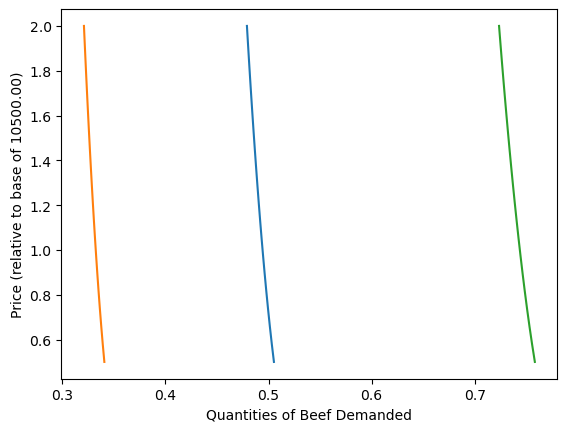

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Beef'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Beef for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Beef for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Beef for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Mapping Nutrient

In [19]:
fct.head()

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


In [20]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Beef', 'Bread', 'Cabbages', 'Chapati', 'Cooking Oil', 'Dodo', 'Eggs',
       'Irish Potatoes', 'Kabalagala', 'Mangos', 'Millet', 'Onions', 'Oranges',
       'Pork', 'Soda', 'Sweet Bananas', 'Tomatoes'],
      dtype='object', name='j')


In [21]:
# The @ operator means matrix multiply
N = fct0.T@c0

N.head()  #NB: Uganda quantities are for previous 7 days

i,00c9353d8ebe42faabf5919b81d7fae7,0e03e253c35d4333a1ffad2df9d38850,1013000202,1021000604,1021000610,1021000709,1021000711,102100110903,1021001301,1021001306,...,_47,_49,_55,a98bebba177243668464e31f6d2bb92d,acb16f9b068549d8a80a37c9d638742f,ad9b7c4ba614444bb8004eb658693c9f,bfd8253bd59c4f3199fb4b83b9cee7a6,bfdf0d66403440ceab439b1e1c47cdea,d24fa50d02c041969a42102d8ebdadc9,e07bc322c4884559b4b8ca75c945dd3e
t,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,...,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20
m,Eastern,Eastern,Central,Central,Central,Central,Central,Central,Central,Central,...,Northern,Northern,Western,Western,Western,Eastern,Eastern,Eastern,Eastern,Northern
n,,,,,,,,,,,,,,,,,,,,,
Energy,6262.286973,11087.199858,16789.662781,7645.099183,19192.066458,35797.950508,12903.893132,32363.367331,14596.627407,10034.101492,...,21187.304384,12862.220669,18417.793212,36123.274412,13046.879607,34033.048124,28948.685596,13077.084553,22639.415467,16851.685908
Protein,153.827423,277.049638,470.130307,205.500171,499.730843,1033.340948,339.970674,912.810301,397.221353,272.093058,...,581.477674,322.910610,485.629776,960.657455,354.700898,874.231829,719.907046,331.408430,564.453236,462.596447
Fiber,84.188533,145.357117,207.638702,96.105823,234.297770,457.297539,161.140051,423.547389,180.216510,129.726398,...,285.051704,172.442107,247.395200,514.410965,179.485827,475.159577,377.926881,176.605746,303.055821,232.192023
Folate,1233.374775,2118.786087,3103.019644,1424.272925,3321.446285,7001.835603,2337.510995,6474.968626,2647.012932,1954.887910,...,4014.129746,2300.941893,3238.163393,6867.710713,2413.051698,7076.821431,5421.305693,2632.540641,4410.117255,3310.578272
Calcium,1703.335740,2970.905199,4332.046314,1995.651129,4731.608541,10108.994405,3269.786114,9003.871321,3707.742642,2740.335400,...,5274.631741,2994.666570,4070.911432,8580.899177,3032.672493,9720.602714,7736.027624,3697.219403,6177.075995,4385.865704


In [22]:
def nutrient_demand(x,p):
    c = result.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

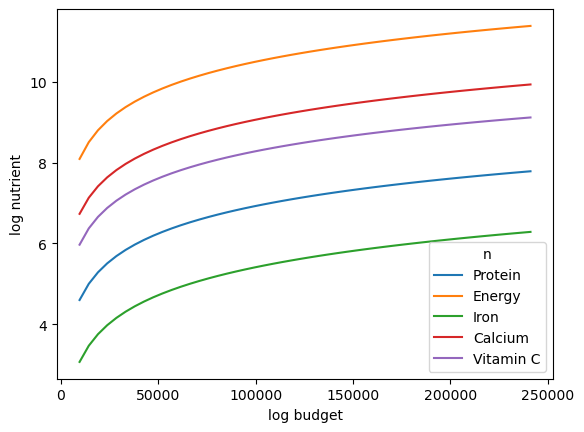

In [23]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

nutrition vary with one food prices

Text(0, 0.5, 'log nutrient')

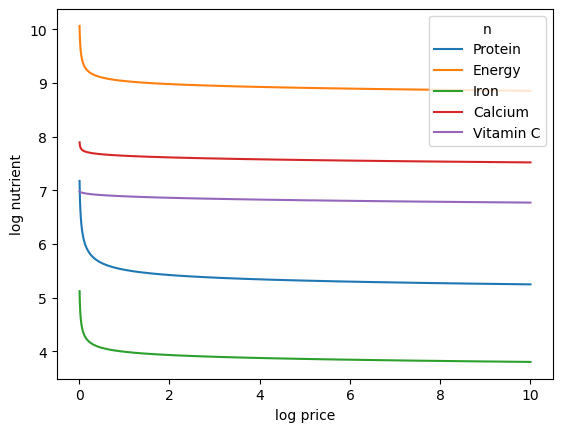

In [24]:
USE_GOOD = 'Beef'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

#### Nutrition Adequecy Ratio

In [25]:
use = fct.index.intersection(qhat.columns)

nutrients = qhat[use]@fct.loc[use,:]

nutrients.mean()

HH_characteristics = read_sheets(InputFiles['HH Characteristics'][0], sheet=InputFiles['HH Characteristics'][1])

if 'm' not in HH_characteristics.columns:
    HH_characteristics['m'] = 1

HH_characteristics = HH_characteristics.set_index(['i','t','m'])
HH_characteristics.columns.name = 'k' 
HH_characteristics=HH_characteristics[['F 04-08', 'F 09-13', 'M 04-08', 'M 09-13']]
HH_characteristics = HH_characteristics.apply(lambda x: pd.to_numeric(x,errors='coerce'))

rdi=rdi[['F 04-08', 'F 09-13', 'M 04-08', 'M 09-13']]
HH_characteristics = HH_characteristics[rdi.columns.tolist()]

hh_rdi = HH_characteristics@rdi.T

#check recommended weekly intake?
hh_rwi = hh_rdi*7
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.497007,0.646334,0.477259,0.587321,0.187180,0.992227,0.694594,0.549575,0.669512,0.783955,0.439542,0.596782,1.315055,3.019858,0.407830
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.565673,0.746765,0.529727,0.605367,0.184528,0.882493,0.545227,0.585865,0.706884,0.840011,0.462487,0.648277,1.458720,3.310190,0.444314
1013000202,2019-20,Central,0.922509,1.767407,0.814909,1.108221,0.309432,1.315725,0.774080,1.200195,1.390248,1.779569,0.802671,1.403358,3.010249,6.094589,0.946487
1021000604,2019-20,Central,0.606754,0.863446,0.544818,0.678225,0.219302,1.193332,0.881596,0.704807,0.821484,1.041694,0.524906,0.818914,1.673747,3.244691,0.538046
1021000610,2019-20,Central,1.713577,2.099709,1.494246,1.581641,0.519957,3.100993,2.144651,1.723530,1.952630,2.556823,1.284482,1.921920,4.151545,7.622846,1.279696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ad9b7c4ba614444bb8004eb658693c9f,2019-20,Eastern,0.784172,1.178210,0.782027,1.010974,0.301882,1.406163,0.873474,0.963814,1.131637,1.346816,0.644298,0.994474,2.277871,5.458541,0.695628
bfd8253bd59c4f3199fb4b83b9cee7a6,2019-20,Eastern,0.939892,1.182113,0.876454,0.968090,0.306985,1.588143,0.991430,0.963278,1.124493,1.369296,0.733812,1.015510,2.364434,5.143520,0.708025
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,0.406121,0.544185,0.391761,0.470097,0.146715,0.698519,0.460369,0.443400,0.532285,0.628357,0.341055,0.483690,1.080179,2.513901,0.334246


Please choose from the following:
'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']




Please input the nutrition you would like to visualize (No quotation mark required):  Energy


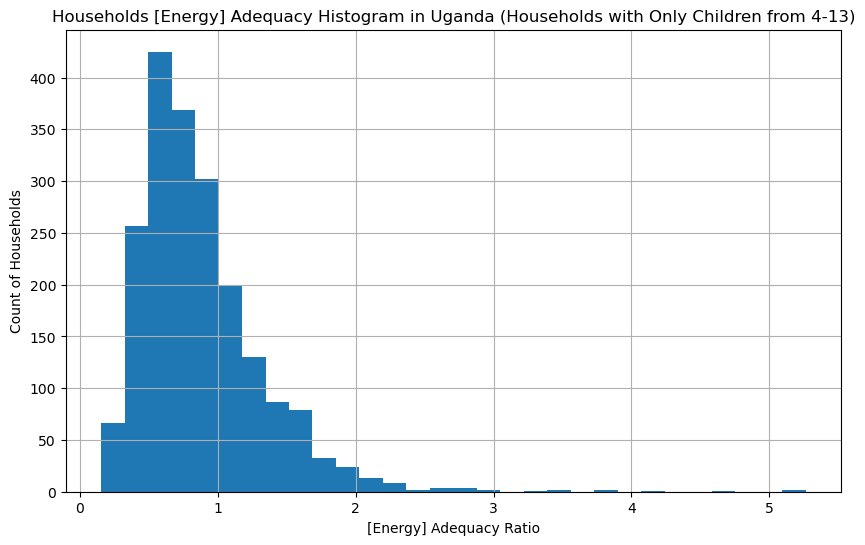

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_nutrition_table(ratio_table, nutrition):
    """
    This function is designed to create a histogram displaying the distribution of nutrition adequacy 
    for households in the Panama Country dataset.

    Parameters:
    - ratio_table (DataFrame): The DataFrame containing the nutrient ratios.
    - nutrition (string): The name of the nutrient column to plot.

    Returns:
    - A histogram for the specified nutrient adequacy among households.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ratio_table[nutrition].hist(ax=ax, bins=30)  # Use ax=ax to plot on the created axes
    plt.title(f'Households [{nutrition}] Adequacy Histogram in Uganda (Households with Only Children from 4-13)')
    plt.xlabel(f'[{nutrition}] Adequacy Ratio')
    plt.ylabel('Count of Households')
    plt.show()


print("Please choose from the following:\n'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']")
print("\n")  
nutrition_input = input('Please input the nutrition you would like to visualize (No quotation mark required): ')
plot_nutrition_table(nutrient_ratio, nutrition_input)

## Policies Analysis

* ### School Meal Box--adding certain food expenditures
* ### Subsidized School Meal Box--reducing certain food prices
* ### Cash Aid --adding to extra budget of family,  $\triangle y_{i}^j$ = $\beta_j * \triangle w_i$ the change in food expenditure euqals change in wealth times beta

    Main Demand System Regression Equation:

    
    <br>
    
    $$
          y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
    $$
    <br>
    
    > $y_{i}^j$ : *__Logarithmic expenditures on food $j$ by household $i$ at a particular time.__*
    > 
    > $A^j(p)$ : *__Sub-function of price $p$ of food $j$. It captures the demand elasticity of food $j$ .__*
    >
    > $\gamma_j'd_i$ : *__Variable $d_i$ represents household characteristics. The coefficient $\gamma_j'$ signifies how food expenditure changes in response to variations in household composition.__*
    >
    > $\beta_j w_i$ : *__Variable $w_i$ represents household wealth. The coefficient $\beta_j$ indicates how changes in household wealth affect food expenditure.__*
    >
    > $\zeta^j_i$ : *__The error term represents all sources of variation in the dependent variable ($y_{i}^j$) that are not explained by the independent variables included in regression function.__*
    
    
    <br>


### School Meal Box--adding certain food expenditures
- #### Our Designed School Meal Box includes "Cassava", "Fish (fresh)", "Maize", "Oranges", "Rice", "Sweet Potato" based on the analysis from food expenditure change on HH characteristic (04-13 children size) plot in Country Based Demand Analysis.ipynb.

In [75]:
###calculate the 04-13 children size in each household
hh_size=d.unstack().sum(axis=1)
# Create a DataFrame from the meal box data
meal_box_data = {
    "j": ["Cassava", "Fish (fresh)", "Maize", "Oranges", "Rice", "Sweet Potatoes"],
    "Quantity (kg)": [45.625, 18.25, 18.25, 47.45, 36.5 , 36.5 ]
}
meal_box_df = pd.DataFrame(meal_box_data).set_index('j')
# Reset the index of hh_size to turn it into columns for merging
hh_size_reset = hh_size.to_frame().rename(columns={0:'hh_size'})

####every child receive one meal box, so we multiply the children size with one meal box quantity
for i in meal_box_df.index:
        hh_size_reset[i]=hh_size_reset['hh_size']*meal_box_df.loc[i, 'Quantity (kg)']

hh_size_food=hh_size_reset.drop('hh_size', axis=1)
xhat_unstack = result.predicted_expenditures().unstack()
hh_size_food_reindexed = hh_size_food.reindex(xhat_unstack.index)
result_df=xhat_unstack[["Cassava", "Fish (fresh)", "Maize", "Oranges", "Rice", "Sweet Potatoes"]].add(hh_size_food_reindexed, fill_value=0)
xhat_unstack.update(result_df)

meal_box_qhat = (xhat_unstack/pbar).dropna(how='all')
    
meal_box_qhat = meal_box_qhat.loc[:,meal_box_qhat.count()>0]
#meal_box_qhat.columns.name='j'

use = fct.index.intersection(meal_box_qhat.columns)
    
nutrients = meal_box_qhat[use]@fct.loc[use,:]
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
meal_box_nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
meal_box_nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.499486,0.648847,0.484796,0.596817,0.190102,1.000847,0.695781,0.551806,0.673732,0.793134,0.441282,0.596782,1.320752,3.132120,0.409017
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.568861,0.749990,0.539417,0.616762,0.187831,0.891113,0.546282,0.588543,0.711949,0.851026,0.464576,0.648277,1.465841,3.454527,0.445775
1013000202,2019-20,Central,0.925942,1.771905,0.825344,1.122465,0.313230,1.324345,0.775029,1.203543,1.396578,1.793338,0.805283,1.403358,3.019745,6.296660,0.948386
1021000604,2019-20,Central,0.609233,0.865960,0.552354,0.687721,0.222224,1.201951,0.882783,0.707039,0.825705,1.050874,0.526647,0.818914,1.679445,3.356953,0.539233
1021000610,2019-20,Central,1.716367,2.102223,1.502724,1.591137,0.522879,3.109612,2.145838,1.725761,1.956850,2.566002,1.286223,1.921920,4.157243,7.735108,1.280883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ad9b7c4ba614444bb8004eb658693c9f,2019-20,Eastern,0.787051,1.181435,0.790779,1.022369,0.305185,1.414782,0.874529,0.966492,1.136702,1.357831,0.646387,0.994474,2.284992,5.602877,0.697088
bfd8253bd59c4f3199fb4b83b9cee7a6,2019-20,Eastern,0.942935,1.185060,0.885703,0.978773,0.310150,1.596763,0.992526,0.965789,1.129241,1.379623,0.735770,1.015510,2.371008,5.275306,0.709382
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,0.409031,0.547132,0.400608,0.480779,0.149880,0.707138,0.461464,0.445911,0.537033,0.638683,0.343014,0.483690,1.086753,2.645687,0.335603


Please choose from the following:
'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']




Please input the nutrition you would like to visualize (No quotation mark required):  Energy


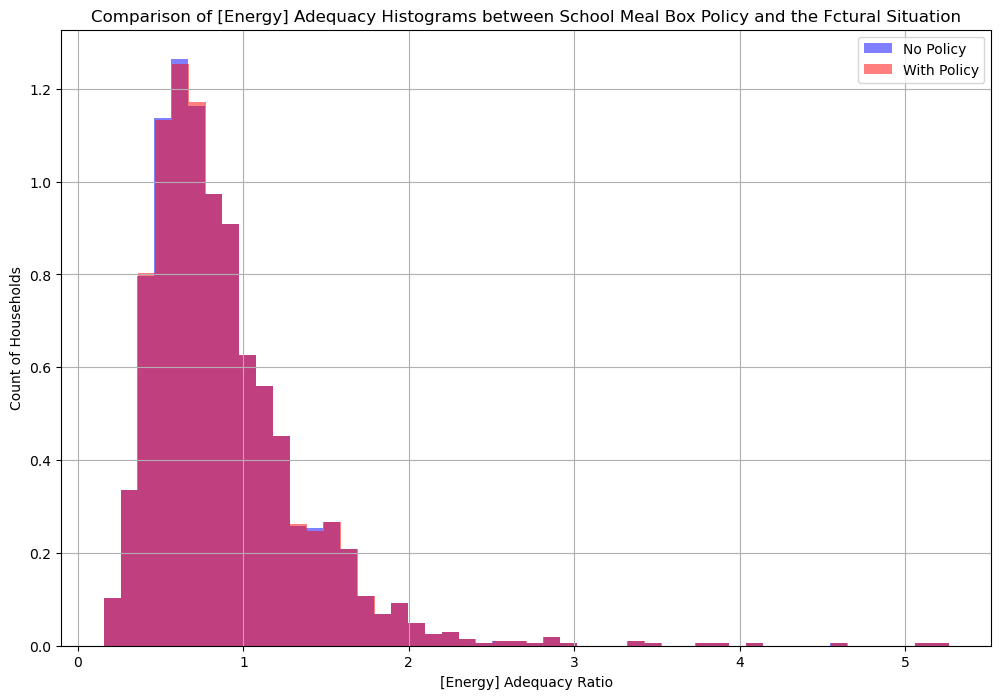

In [89]:
%matplotlib inline
def plot_nutrition_comparison(ratio_table1, ratio_table2, nutrition):
    """
    This function creates a histogram displaying the distribution of nutrition adequacy 
    for households in two datasets, allowing for direct comparison.

    Parameters:
    - ratio_table1 (DataFrame): The first DataFrame containing the nutrient ratios.
    - ratio_table2 (DataFrame): The second DataFrame containing the nutrient ratios.
    - nutrition (string): The name of the nutrient column to plot.

    Returns:
    - A histogram for the specified nutrient adequacy among households from both datasets.
    """
    # Create the plot with specified colors
    fig, ax = plt.subplots(figsize=(12, 8))
    ratio_table1[nutrition].hist(ax=ax, bins=50, density=True, alpha=0.5, label='No Policy', color='blue')
    ratio_table2[nutrition].hist(ax=ax, bins=50, density=True,alpha=0.5, label='With Policy', color='red')
    
    # Add titles and labels
    plt.title(f'Comparison of [{nutrition}] Adequacy Histograms between School Meal Box Policy and the Fctural Situation')
    plt.xlabel(f'[{nutrition}] Adequacy Ratio')
    plt.ylabel('Count of Households')
    plt.legend()
    plt.show()

print("Please choose from the following:\n'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']")
print("\n")  
nutrition_input = input('Please input the nutrition you would like to visualize (No quotation mark required): ')
plot_nutrition_comparison(nutrient_ratio, meal_box_nutrient_ratio, nutrition_input)


- ### Subsidized School Meal Box--reducing 40% of Prices for Food in School Meal Box

In [30]:
def my_prices(d, p=pbar,j='Millet'):
    """
    Discount price of jth good by rate d, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p.loc[j]*(1-d)
    return p

In [31]:
discount=0.4
sub_p=pbar.copy()
for i in meal_box_df.index:
    sub_p=my_prices(discount, sub_p, j=i)

xhat=result.predicted_expenditures()
sub_meal_qhat = (xhat.unstack()/sub_p).dropna(how='all')
    
sub_meal_qhat = sub_meal_qhat.loc[:,sub_meal_qhat.count()>0]
    
use = fct.index.intersection(sub_meal_qhat.columns)
    
nutrients = sub_meal_qhat[use]@fct.loc[use,:]
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
sub_meal_nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
sub_meal_nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.507445,0.656915,0.508986,0.627297,0.199480,1.028513,0.699591,0.558969,0.687278,0.822598,0.446870,0.596782,1.339040,3.492455,0.412827
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.575914,0.757125,0.560854,0.641973,0.195139,0.910182,0.548617,0.594468,0.723154,0.875396,0.469198,0.648277,1.481598,3.773859,0.449007
1013000202,2019-20,Central,0.934888,1.783627,0.852536,1.159583,0.323128,1.346806,0.777504,1.212265,1.413075,1.829218,0.812088,1.403358,3.044490,6.823235,0.953335
1021000604,2019-20,Central,0.615310,0.872120,0.570824,0.710993,0.229385,1.223074,0.885692,0.712508,0.836048,1.073370,0.530914,0.818914,1.693408,3.632077,0.542142
1021000610,2019-20,Central,1.730820,2.115247,1.546654,1.640338,0.538018,3.154272,2.151988,1.737323,1.978717,2.613563,1.295243,1.921920,4.186763,8.316772,1.287033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ad9b7c4ba614444bb8004eb658693c9f,2019-20,Eastern,0.804756,1.201265,0.844594,1.092437,0.325494,1.467782,0.881017,0.982958,1.167843,1.425563,0.659233,0.994474,2.328785,6.490401,0.706072
bfd8253bd59c4f3199fb4b83b9cee7a6,2019-20,Eastern,0.955116,1.196857,0.922726,1.021535,0.322821,1.631264,0.996912,0.975838,1.148246,1.420959,0.743610,1.015510,2.397323,5.802820,0.714812
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,0.415070,0.553245,0.418961,0.502941,0.156447,0.725020,0.463737,0.451119,0.546883,0.660107,0.347077,0.483690,1.100391,2.919083,0.338417


Please choose from the following:
'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']




Please input the nutrition you would like to visualize (No quotation mark required):  Energy


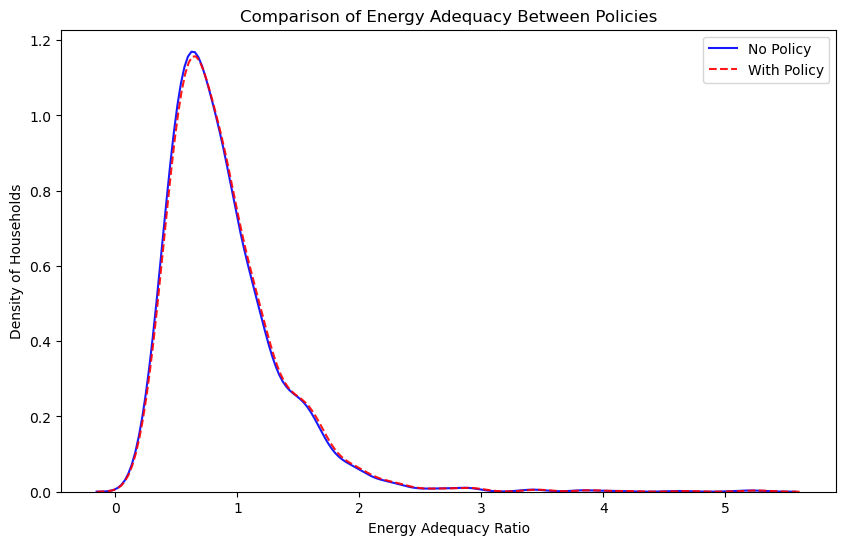

In [40]:

%matplotlib inline
def plot_nutrition_comparison(ratio_table1, ratio_table2, nutrition):
    """
    This function creates a density plot displaying the distribution of nutrition adequacy 
    for households in two datasets, allowing for direct comparison.

    Parameters:
    - ratio_table1 (DataFrame): The first DataFrame containing the nutrient ratios.
    - ratio_table2 (DataFrame): The second DataFrame containing the nutrient ratios.
    - nutrition (string): The name of the nutrient column to plot.

    Returns:
    - A density plot for the specified nutrient adequacy among households from both datasets.
    """
    # Create the plot with specified colors
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=ratio_table1, x=nutrition, fill=False, alpha=0.9, label='No Policy', color='blue')
    sns.kdeplot(data=ratio_table2, x=nutrition, fill=False, alpha=0.9, label='With Policy', color='red', linestyle="--")
    
    # Add titles and labels
    plt.title(f'Comparison of {nutrition} Adequacy Between Policies')
    plt.xlabel(f'{nutrition} Adequacy Ratio')
    plt.ylabel('Density of Households')
    plt.legend()
    plt.show()

print("Please choose from the following:\n'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']")
print("\n")  
nutrition_input = input('Please input the nutrition you would like to visualize (No quotation mark required): ')
plot_nutrition_comparison(nutrient_ratio, sub_meal_nutrient_ratio, nutrition_input)

- ### Cash Aid--$300 per household
- Again, for households only included 4-13 children, we need mutiply children_ratio to 10000 aid

In [100]:
def cash_aid(amount):
    beta=result.get_beta()
    xhat = result.predicted_expenditures()
    weighted_cash_aid=children_ratio*amount
    cash_aid_xhat=xhat.unstack('j')
    cash_aid_xhat=cash_aid_xhat.merge(weighted_cash_aid, how='left', left_index=True, right_index=True)
    for i in cash_aid_xhat.columns:
        if i in beta:
            cash_aid_xhat[i]=cash_aid_xhat[i]+cash_aid_xhat['children_ratio']*beta[i]
    cash_aid_xhat=cash_aid_xhat.drop('children_ratio', axis=1)
    cash_aid_qhat = (cash_aid_xhat/pbar).dropna(how='all')
    
    cash_aid_qhat = cash_aid_qhat.loc[:,cash_aid_qhat.count()>0]
    cash_aid_qhat.columns.name='j'
    
    use = fct.index.intersection(cash_aid_qhat.columns)
    
    nutrients = cash_aid_qhat[use]@fct.loc[use,:]
    use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
    nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

    return nutrient_ratio

cash_aid=cash_aid(300)
cash_aid

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.547324,0.690809,0.524125,0.637328,0.203653,1.100920,0.755242,0.590526,0.719381,0.848411,0.490353,0.620631,1.446675,3.317547,0.436265
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.656244,0.826652,0.614086,0.689378,0.210599,1.034664,0.620700,0.654663,0.790665,0.948297,0.547850,0.688343,1.689055,3.846032,0.493309
1013000202,2019-20,Central,1.085071,1.953111,0.966321,1.283243,0.359401,1.569342,0.887289,1.343525,1.564791,2.005165,0.980513,1.486828,3.522106,7.344884,1.052644
1021000604,2019-20,Central,0.657071,0.907921,0.591683,0.728232,0.235776,1.302025,0.942244,0.745759,0.871354,1.106150,0.575718,0.842762,1.805368,3.542381,0.566481
1021000610,2019-20,Central,1.792826,2.161975,1.568060,1.651650,0.543019,3.253163,2.229558,1.780861,2.022447,2.647061,1.355618,1.955308,4.335814,8.039612,1.319505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ad9b7c4ba614444bb8004eb658693c9f,2019-20,Eastern,0.818257,1.211497,0.813775,1.045979,0.312745,1.469567,0.904921,0.992480,1.166546,1.391935,0.679867,1.011168,2.373844,5.681808,0.716042
bfd8253bd59c4f3199fb4b83b9cee7a6,2019-20,Eastern,1.001645,1.234257,0.933971,1.024347,0.324831,1.696836,1.047413,1.009349,1.180596,1.441809,0.790975,1.042340,2.516304,5.492982,0.740522
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,0.452062,0.584741,0.434551,0.513852,0.160595,0.783058,0.503911,0.479233,0.575921,0.684756,0.385516,0.504558,1.198300,2.785705,0.359522


Please choose from the following:
'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']




Please input the nutrition you would like to visualize (No quotation mark required):  Energy


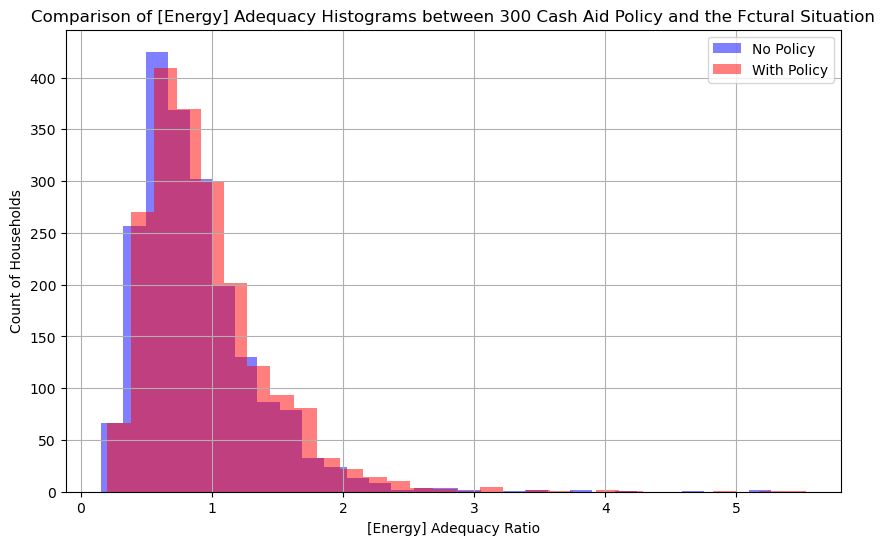

In [101]:
def plot_nutrition_comparison(ratio_table1, ratio_table2, cash_amount, nutrition):
    """
    This function creates a histogram displaying the distribution of nutrition adequacy 
    for households in two datasets, allowing for direct comparison.

    Parameters:
    - ratio_table1 (DataFrame): The first DataFrame containing the nutrient ratios.
    - ratio_table2 (DataFrame): The second DataFrame containing the nutrient ratios.
    - nutrition (string): The name of the nutrient column to plot.

    Returns:
    - A histogram for the specified nutrient adequacy among households from both datasets.
    """
    # Create the plot with specified colors
    fig, ax = plt.subplots(figsize=(10, 6))
    ratio_table1[nutrition].hist(ax=ax, bins=30, alpha=0.5, label='No Policy', color='blue')
    ratio_table2[nutrition].hist(ax=ax, bins=30, alpha=0.5, label='With Policy', color='red')
    
    # Add titles and labels
    plt.title(f'Comparison of [{nutrition}] Adequacy Histograms between {cash_amount} Cash Aid Policy and the Fctural Situation')
    plt.xlabel(f'[{nutrition}] Adequacy Ratio')
    plt.ylabel('Count of Households')
    plt.legend()
    plt.show()

print("Please choose from the following:\n'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']")
print("\n")  
nutrition_input = input('Please input the nutrition you would like to visualize (No quotation mark required): ')
plot_nutrition_comparison(nutrient_ratio, cash_aid, 300, nutrition_input)
